# Adversarial Patch

In [9]:
import sys
sys.path.append('C:/Users/gdkpy/Documents/Patch-Attacks_tensorflow-main/adversarial-robustness-toolbox')

import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch

# Settings

In [10]:
target_name = 'toaster'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes  =1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 2

# Model definition

In [11]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=nb_classes,
                             input_shape=image_shape, clip_values=clip_values, 
                             preprocessing=([mean_b, mean_g, mean_r], np.array([1.0, 1.0, 1.0])))

# Coco training images

In [12]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]

In [13]:
import os 
from tensorflow.keras.utils import load_img, img_to_array
images = []
counter = 0
for image in os.listdir("D:/Sorbonne/m2s1/Machine_Learning_Avance/projet/coco/train2017/train2017"):
    img = load_img('D:/Sorbonne/m2s1/Machine_Learning_Avance/projet/coco/train2017/train2017/'+image, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)
    counter += 1
    if counter > 10:
        break
images = np.vstack(images)

In [14]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = load_img(image_path, target_size=(224, 224))
    im = img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images_test = np.vstack(images_list)

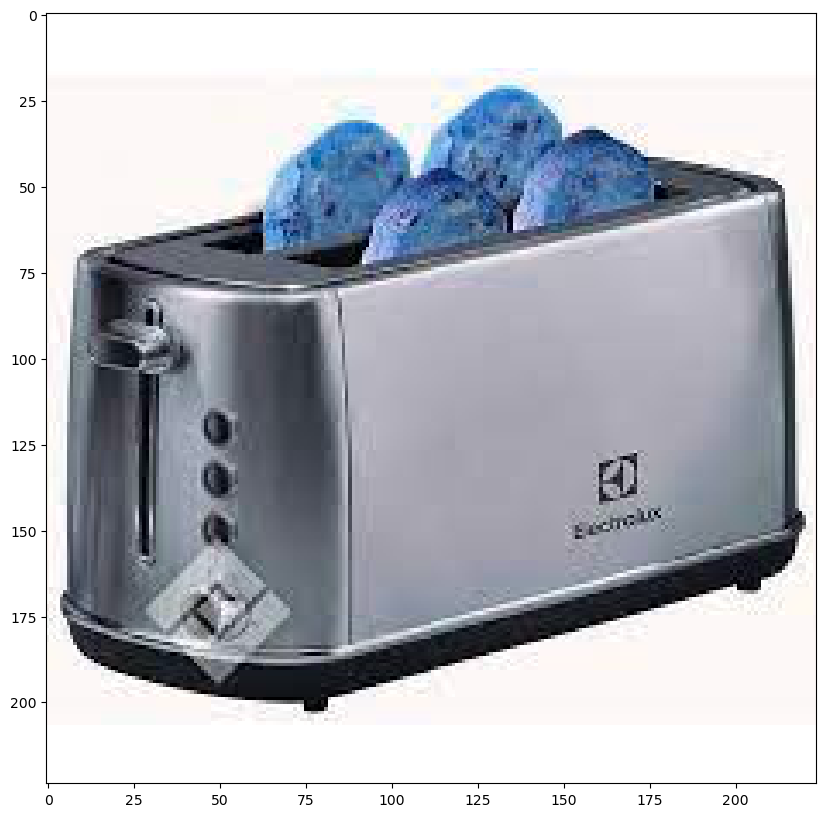

In [46]:
image_toaster = load_img('D:/Sorbonne/m2s1/Machine_Learning_Avance/projet/toaster.jfif', target_size=(224, 224))
image_toaster = img_to_array(image_toaster)
image_toaster = bgr_to_rgb(image_toaster.astype(np.uint8))
plt.imshow(image_toaster.astype(np.uint8))
plt.show()

In [27]:
import cv2
cv2.imshow('toaster' , image_toaster)
cv2.waitKey(0)

-1

# Adversarial patch generation

In [16]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=0.5,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

label = name_to_label(target_name)
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images_test.shape[0], 1))
patch, patch_mask = ap.generate(x=images_test, y=y_target)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Adversarial Patch TensorFlow v2:   0%|          | 0/2 [00:00<?, ?it/s]

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(16, 1000), dtype=float64)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(16, 1000), dtype=float64)


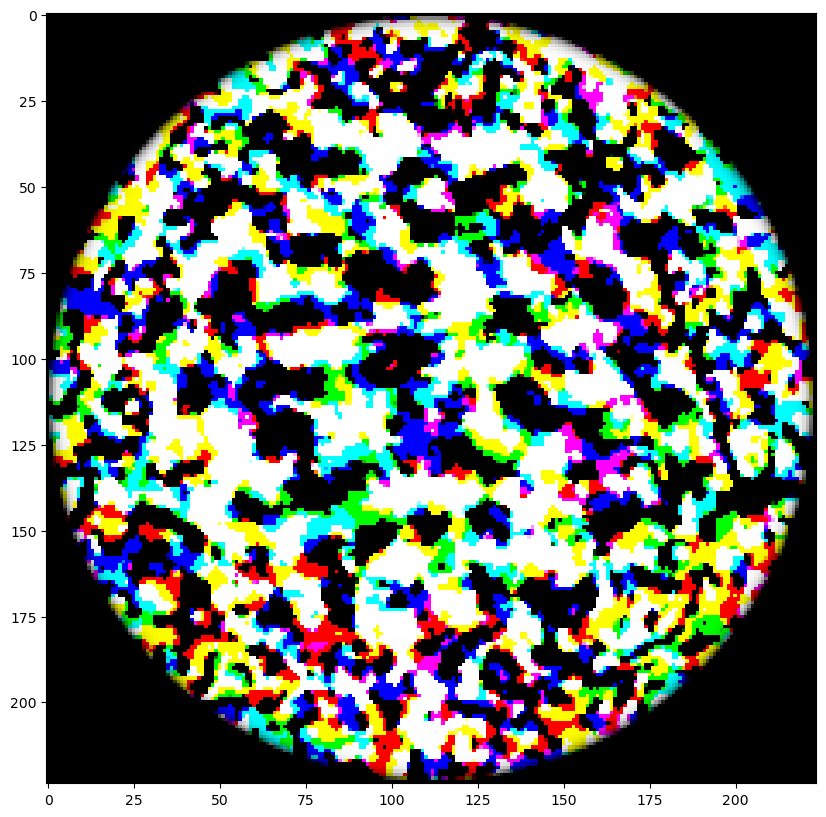

In [17]:
plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint8))

# Evaluation

In [18]:
def predict_model_plot(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
        
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name1 = prediction_decode[i][1]
        name = name1.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)
        if (name1 == "toaster") :
            success=probability
            return success
    return 0

In [19]:
def predict_model(classifier, image):
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
        
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name1 = prediction_decode[i][1]
        name = name1.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)
        if (name1 == "toaster") :
            success=probability
            return success
    return 0

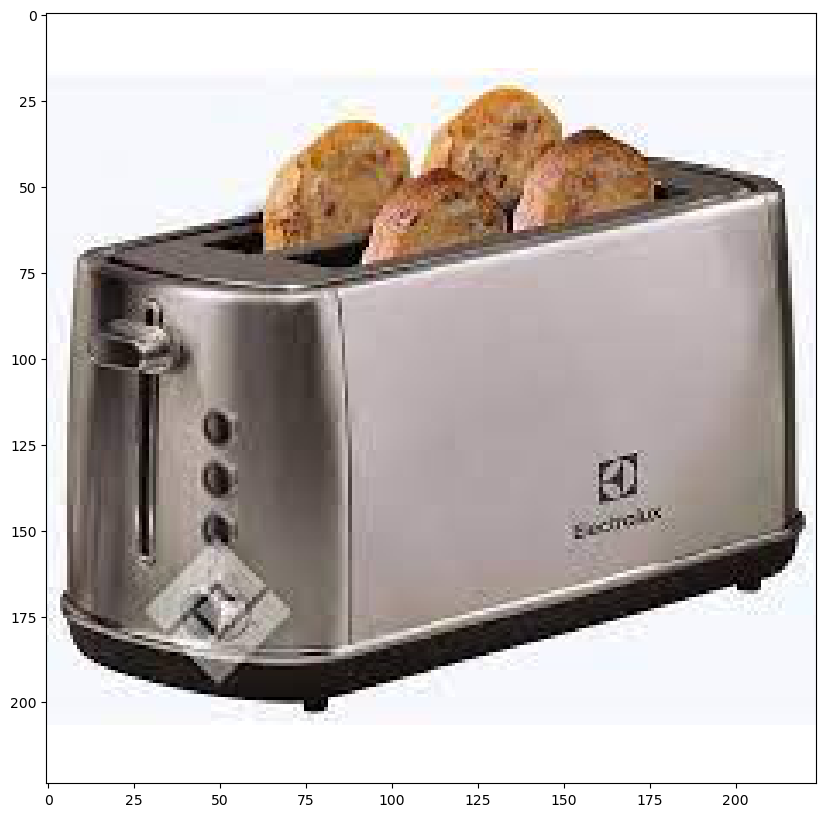

Predictions:
toaster          1.00


0.99999535

In [47]:
predict_model_plot(tfc, image_toaster)

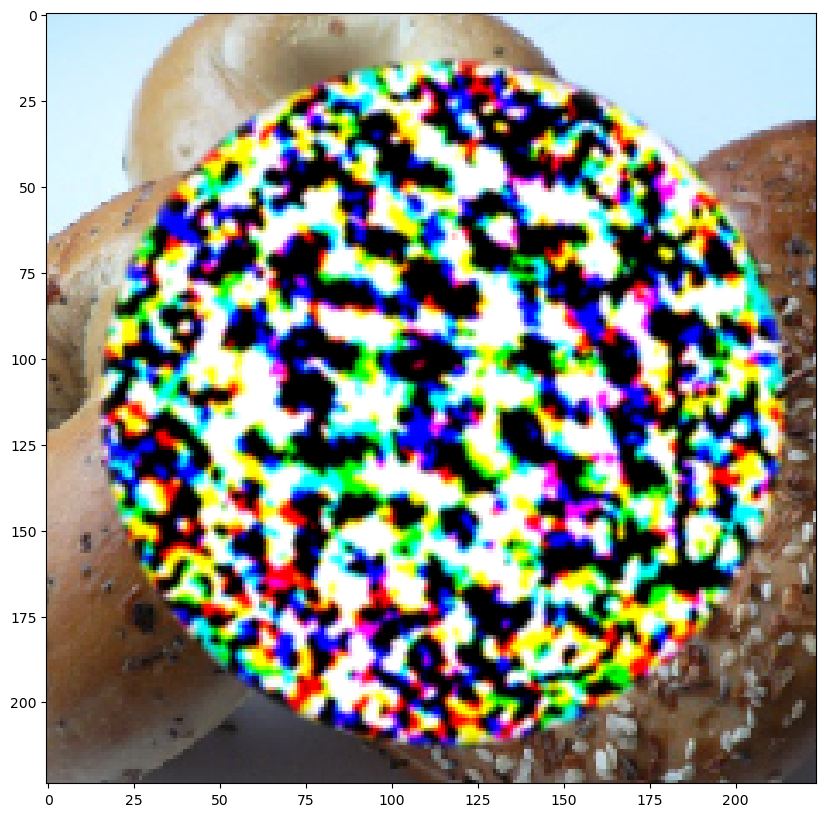

Predictions:
ice_cream 0.55
pinwheel  0.18
maraca    0.15
coil      0.04
bakery    0.01


0

In [48]:
patched_images = ap.apply_patch(images_test, scale=0.9)
predict_model_plot(tfc, patched_images[0])

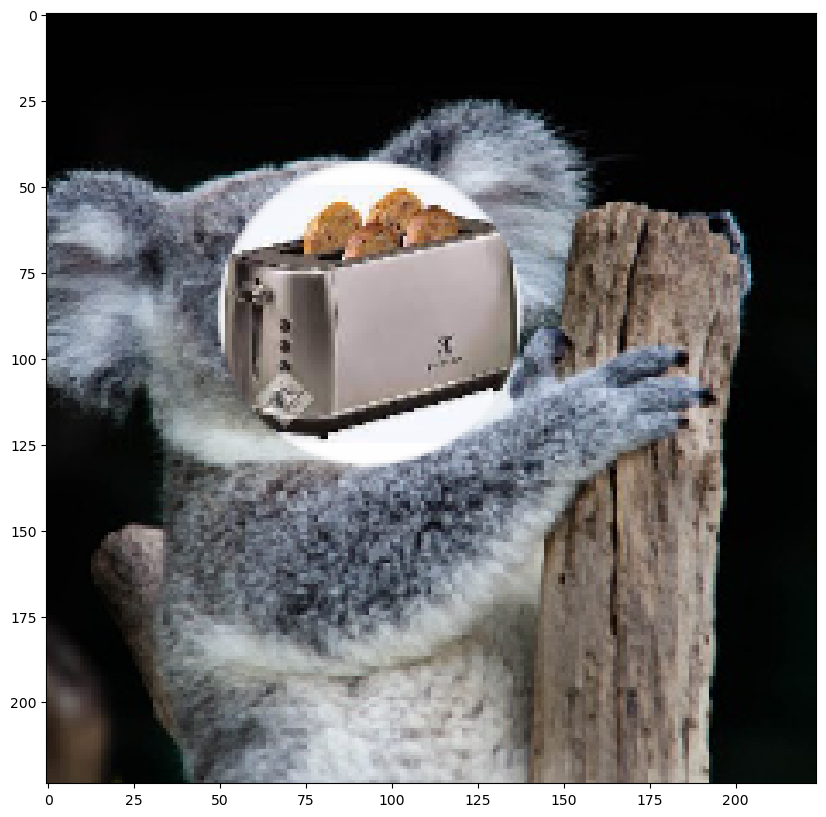

Predictions:
koala     0.59
lighter   0.22
toaster   0.08


0.076592505

In [58]:
toaster_images = ap.apply_patch(x=images_test, scale=0.4, patch_external=image_toaster,toaster=True)
predict_model_plot(tfc, toaster_images[5])

Predictions:
bagel        1.00
pretzel      0.00
bakery       0.00
sea_cucumber 0.00
Granny_Smith 0.00
Predictions:
beagle           0.94
Walker_hound     0.03
English_foxhound 0.02
basset           0.00
bluetick         0.00
Predictions:
centipede        1.00
starfish         0.00
flatworm         0.00
alligator_lizard 0.00
night_snake      0.00
Predictions:
flagpole   1.00
pole       0.00
safety_pin 0.00
maypole    0.00
worm_fence 0.00
Predictions:
gazelle    1.00
impala     0.00
hartebeest 0.00
bustard    0.00
llama      0.00
Predictions:
koala          1.00
indri          0.00
fox_squirrel   0.00
Madagascar_cat 0.00
wombat         0.00
Predictions:
malamute           0.67
Siberian_husky     0.22
Eskimo_dog         0.11
timber_wolf        0.00
Norwegian_elkhound 0.00
Predictions:
manhole_cover 1.00
brass         0.00
sundial       0.00
safe          0.00
mailbox       0.00
Predictions:
marmoset 0.83
titi     0.17
capuchin 0.00
colobus  0.00
langur   0.00
Predictions:
mitten   1.00
s

Text(0, 0.5, 'Attack succes rate')

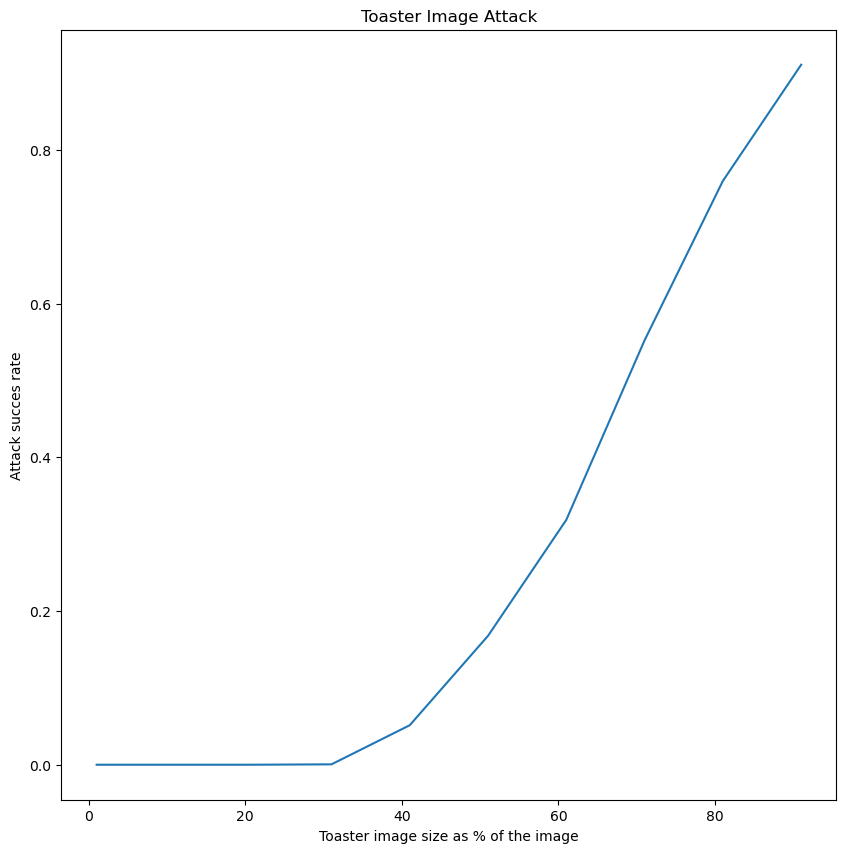

In [62]:
x=np.arange(1,101,10)
success_obt=[]
for i in x :
    success = 0
    for j in range(16):
        patched_images = ap.apply_patch(x=images_test, scale=0.01*i, patch_external=image_toaster)
        success += predict_model(tfc, patched_images[j])
    success /= 16
    success_obt.append(success)
plt.plot(x,success_obt)
plt.title("Toaster Image Attack")
plt.xlabel("Toaster image size as % of the image")
plt.ylabel("Attack succes rate")

scale = 0.01
Predictions:
bagel        1.00
pretzel      0.00
bakery       0.00
sea_cucumber 0.00
Granny_Smith 0.00
scale = 0.01
Predictions:
beagle           0.94
Walker_hound     0.03
English_foxhound 0.02
basset           0.00
bluetick         0.00
scale = 0.01
Predictions:
centipede        1.00
starfish         0.00
flatworm         0.00
alligator_lizard 0.00
night_snake      0.00
scale = 0.01
Predictions:
flagpole   1.00
pole       0.00
safety_pin 0.00
maypole    0.00
worm_fence 0.00
scale = 0.01
Predictions:
gazelle    1.00
impala     0.00
hartebeest 0.00
bustard    0.00
llama      0.00
scale = 0.01
Predictions:
koala          1.00
indri          0.00
fox_squirrel   0.00
Madagascar_cat 0.00
wombat         0.00
scale = 0.01
Predictions:
malamute           0.66
Siberian_husky     0.22
Eskimo_dog         0.11
timber_wolf        0.00
Norwegian_elkhound 0.00
scale = 0.01
Predictions:
manhole_cover 1.00
brass         0.00
sundial       0.00
safe          0.00
mailbox       0.00
scale =

Text(0, 0.5, 'Attack succes rate')

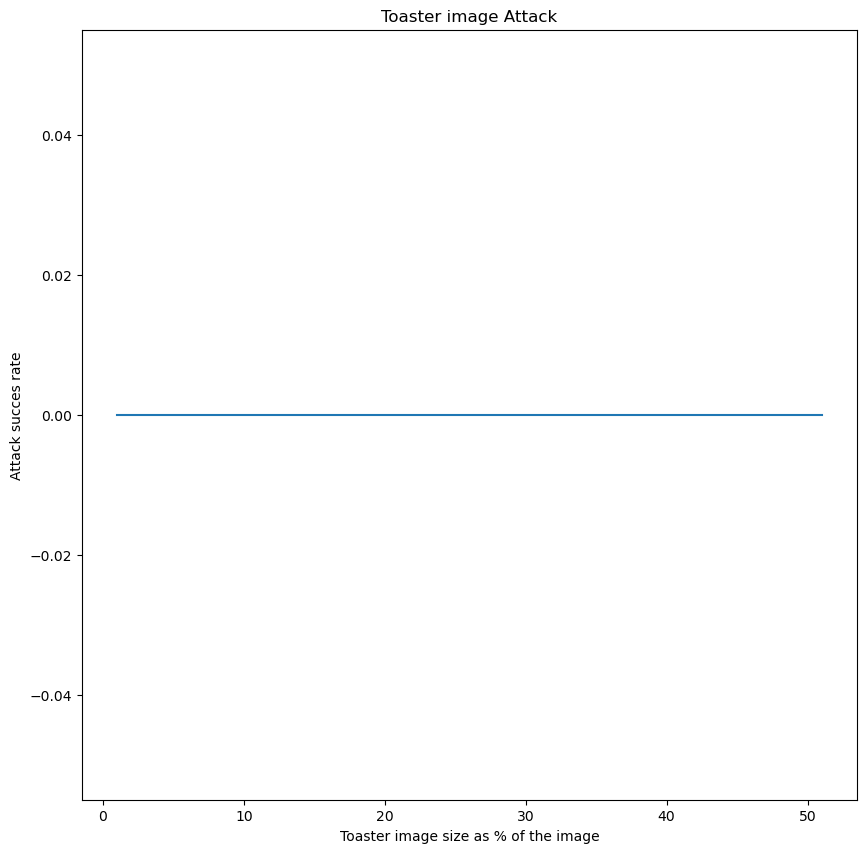

In [60]:
x=np.arange(1,101,2)
success_obt=[]
for i in x :
    success = 0
    for j in range(16):
        patched_images = ap.apply_patch(images_test, scale=0.01*i)
        print("scale =", 0.01*i)
        success += predict_model(tfc, patched_images[j])
    success /= 16
    success_obt.append(success)
plt.plot(x,success_obt)
plt.title("Toaster image Attack")
plt.xlabel("Toaster image size as % of the image")
plt.ylabel("Attack succes rate")

In [132]:
print("done")

done
